In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(24680)

In [4]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

from joblib import dump, load

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

from time import time

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC

# Digits recognizer
### Разпознаване на ръчно написани цифри чрез алгоритми за машинно обучение (PCA, K-Nearest Neighbors, Logistic Regression and SVM)

### Увод
Проектът е фокусиран върху разпознаването на ръчно написани цифри. Идея е да създадем модел, който е способен с висока точност да идентифицира цифри от изображения. Този модел може да се приложи в следните сфери:

- 	Банкови услуги Автоматично разпознаване на ръчно попълнени чекове и формуляри за по-ефективни финансови транзакци
- Медицина - Разпознаване на ръчно написани бележки и рецепти, улеснявайки процесите на документация и управление на пациентски дан
- Образованиен - Разпознаване на ръчно написани отговори на тестове и домашни работи за по-бърза и ефективна оцен  



Моделът приема снимка, на която има ръчно написана цифра и разпознава коя е цифрата.

В този проект ще проучим колко добре различни популярни алгоритми за машинно обучение обработват многомерни данни (снимката я представяме като двумерен масив). Извършваме Principal Component Analysis върху характеристиките, за да намалим размерността и ускорим обучението на моделите. В този случай PCA се използва като техника за избор на характеристики, за да се намали размерността и така да улесни Gaussian SVM алгоритъма да извърши задачата по класификацията на ръчно писани цифри.
Ще видим, че най-добрият модел по отношение на точността върху тестовия набор от данни е Gaussian SVM с 98%, въпреки че обучението му е доста бавно. Не много далеч с точност от 97% върху тестовия набор е методът на K-Nearest Neighbors, който е много по-бърз за обучение. Логистичната регресия е най-бързата за обучение, но достига само 90% точност. Останалите алгоритми (Decision Tree, Random Forrest, AdaBoost and LinearSVC) се справят по-слабо по отношение на точността в метриките за cross-validation. 


### Преглед на областa на разпознаване на ръчно написани символи 
В областта на разпознаването на ръчно написани символи, наблюдаваме активен напредък като се използват различни подходи и техники. Изследванията включват не само традиционни методи, но и иновации, фокусирани върху машинното обучение и невронните мрежи.

Невронните мрежи изпъкват като ключов инструмент за постигане на висока точност и ефективност. Различни архитектури като конволюционни невронни мрежи (CNN) се използват за подобряване на способностите за разпознаване на различни стилове на ръкопис. Трансферното обучение с невронни мрежи се проучва за увеличаване на темповете на обучение и адаптиране към различни стилове на писане. Рекурентните невронни мрежи (RNN) от своя страна подобряват разпознаването на последователни и свързани символи
.
Тези иновации представляват ключов фактор за постигане на висока прецизност в разпознаването на ръчно написани цифри. Нашият проект се насочва към интегриране на тези напредъци в създаването на модел, който не само отговаря на изискванията на различни бизнес сфери, където разпознаването на ръчно написани символи е от съществено значение, но и предоставя иновативни решения за бъдещет
о.
Текущото състояние на тази област показва нарастващ интерес и приложения във всички сфери на бизнеса, като търсенето на ефективни решения за разпознаване на ръчно написани символи продължава да расте.
В областта се използват и различни видове алгоритми за машинно обучение за справяне с предизвикателствата. Цялостно се прилагат различни технологии и иновации, за да се подобряват вече съществуващи модели и разпознаването на ръчно написан текст да става все по-точо. 


## Данни
- Използваме данни от [Kaggle](https://www.kaggle.com/c/digit-recognizer/data)
- Оригиналният dataset на ръчно написани цифри включва обучителен набор от 60,000 примера и тестов набор от 10,000 примера
- Kaggle dataset съдържа два файла - train.csv и test.csv - и двата съдържат ръчно написани цифри от нула до девет
- Всяка картинка е **28** пиксела висока и **28** пиксела широка, което прави общо **784** пиксела
- **Всеки пиксел има единична стойност, която показва колко е светъл или тъмен този пиксел, като по-големите числа означават по-тъмни. Тази стойност е цяло число между 0 и 255, включително**
- Обучителният dataset (train.csv) има 785 колони. Първата колона, наречена "label", е цифрата, нарисувана от потребителя. Останалите колони съдържат стойностите на пикселите на съответната картинка. Файлът съдържа **42,000 наблюдения**
- Всяка колона с пиксели в обучителния набор има име като pixel_x, където x е цяло число между 0 и 783, включително. За да намерите този пиксел на картинката, предположете, че сте разложили x като x = i * 28 + j, където i и j са цели числа между 0 и 27, включително. Тогава pixel_x се намира в ред i и колона j на матрица 28 x 28 (индексиране от нула)
    - Например, pixel_32 показва пиксела, който е в петата колона от ляво и втория ред отгоре
- Тестовият dataset (test.csv) е същият като обучителния, с изключение на това, че не съдържа колоната "label"
- Ще използваме само train.csv, за да можем да разделим данните сами

### Работен процес
1.	Ще отделим характеристиките (features) от етикетите (labels)
2.	На второ място, ще скалираме характеристиките (features), така че да можем да приложим PCA – превръщаме стойността на всяка колона в диапазона от 0 до 1 използвайки MixMaxScaler
3.	Извършваме PCA
4.	Разделяме набора данни на 2 части - обучаващ и тестов поднабор
5.	Използваме обучаващия набор, за да оценим средната точност при cross-validation на няколко алгоритъма и да изберем три най-добре представящи се. Тестваме Decision Trees, Random Forests, AdaBoost, Logistic Regression, Linear SVM, Gaussian SVM, K-Nearest Neighbors. Избираме три с най-висока средна точност при крос валидация
6.	Извършваме grid search върху трите алгоритъма, които са в краткия списък, с цел да ги подобрим
7.	Тестваме моделиte върху тестовия набор
8.	Запазваме обучените модели като файлове за бъдещи корекции и също така запазваме Excel файл с някои важни параметри на трите модела, което позволява последващи анализи и, надяваме се, оптимизация.
9.	Оценяваме ефективността на най-добрия алгоритъм, използвайки различен брой характеристики и повторно извършваме grid search. Извършваме PCA, за да достигнем explained variance от 60%, 70%, 80%, 90% и 95%, като по този начин получаваме различни характеристики. Повторно обучаваме най-добрия алгоритъм с различните характеристики чрез grid search, за да намерим най-добрия набор от характеристики, водещ до най-висока точност без да попадаме в сценарии на overfitting.
10.	Намираме най-добрия модел, който постига 98% точност


### Дефиниране на помощни функции
Започваме с дефиниране на някои функции, които ще бъдат често използвани. 
Ще дефинираме помощна функция **fit_model**, която ще извърши grid search върху нашите модели и ще върне речник със следната информация: 
 - **model** - съдържа името на алгоритъма 
- **number_features_training** - съдържа броя на характеристиките в текущия модел 
- **explained_variance_after_pca** - показва explained variance след намаляването на размерността, извършено от PCA 
- **best_estimator** - съдържа най-добрия модел от проведения grid search
- **best_params** - съдържа най-добрите хиперпараметри, които дават най-високите метрики (в нашия случай "точност")
- **best_score** - съдържа най-високият резултат за точност
- **time_sec** - съдържа времето за изпълнение на grid_search 

Този речник се добавя към списъка модели, където ще събираме гореспоменатата информация за всеки алгоритъм. Накрая ще създадем DataFrame от списъка 
с модели и ще го запазим като Excel файл. Това се извършва от помощната функция **persist_data**, която също така запазва модела.

Също така дефинираме някои функции за изчертаване, които ще ни помогнат да визуализираме цифрите и матрицата по по-приятен начин.

In [5]:
# performs grid search on the model
def fit_model(model, parameters_grid, k_fold):   
    t0 = time()    
    grid_search = GridSearchCV(model, parameters_grid, n_jobs = 1,scoring = 'accuracy', cv = k_fold)
    grid_search.fit(X_tr, y_tr)
    t1 = time()-t0
    
    return{"model":model.__class__.__name__,
           "number_of_observations_training":X_tr.shape[0],
           "number_features_training":X_tr.shape[1],
           "explained_variance_after_pca":explained_variance,
           "best_estimator":grid_search.best_estimator_,
           "best_params": grid_search.best_params_,
           "best_score": grid_search.best_score_,
           "time_sec": t1}

In [45]:
# saves model on the disc and best model parameters in Excel
def persist_data(models, model_fit):
    #save to disc model
    filename = model_fit['model']+".sav"
    dump(model_fit,filename)
    models.append(model_fit)
    model_df = pd.DataFrame.from_dict(models)
    writer = pd.ExcelWriter("output.xlsx")
    model_df.to_excel(writer,'Sheet1')
    writer.close()

In [7]:
# plots the confusion matrix
def draw_confusion_marix(y_ts, predictions, score):
    cm = confusion_matrix(y_ts, predictions)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt="", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0:.3%}'.format(score)
    plt.title(all_sample_title, size = 15);

## Зареждане и анализиране на данните

In [8]:
data = pd.read_csv('data/train.csv')

In [9]:
data.tail(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
41990,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41991,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41992,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41993,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41994,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41999,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
data.shape

(42000, 785)

In [11]:
data.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


## Визуализиране на данните

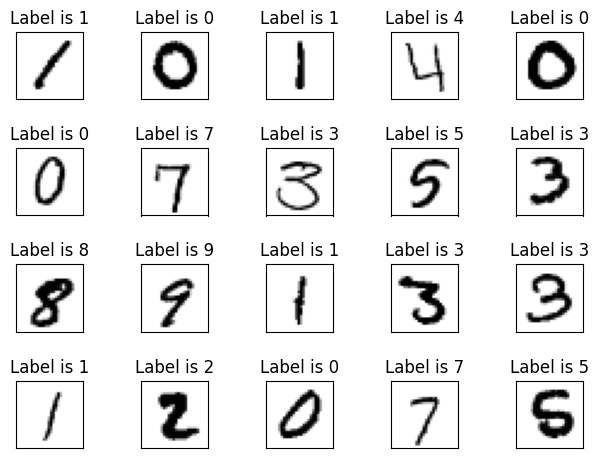

In [12]:
# Plots a single image
def plot_digit(row, w = 28, h = 28, labels = True):
    if labels:
        # the first column contains the label
        label = row.iloc[0]
        # The rest of columns are pixels
        pixels = row[1:]
    else:
        label = ''
        # The rest of columns are pixels
        pixels = row[0:]
    
#    print(row.shape, pixels.shape)
        

    # Make those columns into a array of 8-bits pixels
    # This array will be of 1D with length 784
    # The pixel intensity values are integers from 0 to 255
    pixels = 255 - np.array(pixels, dtype = 'uint8')

    # Reshape the array into 28 x 28 array (2-dimensional array)
    pixels = pixels.reshape((w, h))

    # Plot
    if labels:
        plt.title('Label is {label}'.format(label = label))
    plt.imshow(pixels, cmap = 'gray')


# Plot pictures
def plot_digits(images, size_w = 28, size_h = 28, labels = True, images_per_row = 5):
    images_count = images.shape[0]
    h = np.ceil(images_count / images_per_row).astype(int)
    fig, plots = plt.subplots(h, images_per_row)
    fig.tight_layout()

    for n in range(0, images_count):
        s = plt.subplot(h, images_per_row, n + 1)
        s.set_xticks(())
        s.set_yticks(())
        plot_digit(images.iloc[n], size_w, size_h, labels)
    plt.show()


plot_digits(data[0:20])

### Разделяме целия dataset на характерситки(features) и етикети(labels)

In [13]:
features = data.drop(['label'], axis='columns', inplace=False)
features.shape

(42000, 784)

In [14]:
labels = data['label']
labels.shape

(42000,)

In [15]:
labels.unique()

array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6], dtype=int64)

In [17]:
label_counts = labels.value_counts()
label_counts

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

Етикетите са почти равномерно разпределени и са представени от сходен брой наблюдения. Няма големи неравенства. Можем да използваме метриката за точност (accuracy).

### Метрики за измерване на производителността на модела
Въпреки че има други начини за измерване на производителността на модела (precision, recall, F1 Score, ROC Curve и др.), ще запазим нещата прости и ще използваме accuracy като наша метрика. Accuracy е подходяща в този случай, защото различните класове са със сходен размер на примерите и изглежда, че са добре балансирани. Също така ще покажем confusion matrix за реални и предсказани етикети и classification report.

### Намаляване на размерността
Обикновено намаляването на размерността се използва по три основни причини: 
- помага за визуализация на данни с висока размерност и откриване на структури или модели
- избира добри характеристики и избягва висока корелация между някои от тях, което води до следващата причина
- ефективно обучение на моделите - по-малки размерности и по-малко характеристики означават по-кратко време за обучение

В този случай ще го използваме, за да намалим броя на характеристиките с цел намаляване на времето за обучение на алгоритмите.мите.

### PCA (Principal Components Analysis)
PCA (Principal Component Analysis) е линейна техника за намаляване на размерността, която се стреми да максимизира дисперсията. 
PCA е въздействан от представянето на данните, затова трябва да скалираме характеристиките в нашите данни преди да приложим PCA. Ще използваме **MinMaxScaler**. Нашата цел е да запазим голяма част от дисперсията и в същото време да намалим броя на характеристиките. Когато по-късно оценяваме моделите, можем да се върнем на този етап и да променим баланса между запазената дисперсия и характеристиките. За начало решаваме да запазим дисперсията до **90%** и да видим резултиращото намаление на характеристиките. По-късно ще се върнем на този етап и ще тестваме избраният алгоритъм при различни комбинации.

In [18]:
scaler = MinMaxScaler().fit(features)
features_scaled = scaler.transform(features)
pca_features = PCA(0.90).fit(features_scaled)

In [19]:
features_scaled_pca = pca_features.transform(features_scaled)

In [20]:
pca_features.n_components_

87

In [21]:
explained_variance = pca_features.explained_variance_ratio_.sum()

In [22]:
explained_variance

0.9005709788011417

Виждаме, че сме запазили 90% от дисперсията и размерностите са били намалени на 87. Намалихме броя на характеристиките с фактор от 9.

### Разделяме данните на обучаващи и тестови
Разделяме набора от характеристики, върху който току-що извършихме скалиране и PCA, на 70% обучиаващи и 30% тестови. Разделяме характеристиките едновременно с етикетите.

In [25]:
X_tr, X_ts, y_tr, y_ts = train_test_split(features_scaled_pca, labels, test_size = 0.30)

In [26]:
print("Shape of training features: "+str(X_tr.shape))
print("Shape of testing features: "+str(X_ts.shape))
print("-------------------------------------------")
print("Shape of training labels: "+str(y_tr.shape))
print("Shape of testing labels: "+str(y_ts.shape))

Shape of training features: (29400, 87)
Shape of testing features: (12600, 87)
-------------------------------------------
Shape of training labels: (29400,)
Shape of testing labels: (12600,)


Обучаващите и тестовите характеристики и етикети изглеждат, че имат правилната форма.

Ще запазим текущият тестов набор от данни, така че да можем да го запазим точно същия за бъдеща употреба, когато тестваме резултатите за запазените модели, които са били обучени с текущото разделяне на обучаващите данни.

In [28]:
test_set = {"X":X_ts, "y":y_ts}
dump(test_set,"test_set-BACKUP.sav")

['test_set-BACKUP.sav']

In [29]:
# Важно
# Разкоментирайте това, ако искате да използвате оригиналния тестов набор от данни 
# заедно със вече запазените модели, които са били обучени със същото разделяне
# test_set_loaded = load('test_set-BACKUP.sav')
# X_ts = test_set_loaded["X"]
# y_ts = test_set_loaded["y"]

### Избиране на алгоритми
Използвайки cross validation с 5 фолда върху обучаващия набор с 'accuracy' като метрика, ще изберем три от най-добрите алгоритъма. Ще ги стартираме с техните настройки по подразбиране. Седемте кандидата са:
* Logistic Regression
* K-Nearest Neighbor
* Decision Tree
* AdaBoost
* Random Forrest
* Linear SVC
* Gaussian SVC




In [30]:
k_fold = KFold(n_splits = 5)

In [31]:
# това отнема около 10 мин
results = []
names = []
scoring = 'accuracy'
algorithms = []
algorithms.append(("LR", LogisticRegression()))
algorithms.append(("KNN", KNeighborsClassifier()))
algorithms.append(("CART", DecisionTreeClassifier()))
algorithms.append(("AdaBoost", AdaBoostClassifier()))
algorithms.append(("RandomForrest", RandomForestClassifier()))
algorithms.append(("LinearSVC", LinearSVC()))
algorithms.append(("GaussianSVM", SVC()))
for name, algorithm in algorithms:
    t0=time()   
    cv_results = cross_val_score(algorithm, X_tr, y_tr, cv= k_fold, scoring = scoring)
    t1 = time() - t0
    results.append(cv_results)
    names.append(name)
    print("{0}: mean accuracy {1:.3%} - standard deviation {2:.4} - time {3:n}".format(name, cv_results.mean(), cv_results.std(), t1))

C:\Users\Atanas.Vasilev\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Atanas.Vasilev\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

LR: mean accuracy 91.398% - standard deviation 0.003034 - time 4.79165
KNN: mean accuracy 96.711% - standard deviation 0.001421 - time 1.90334
CART: mean accuracy 80.524% - standard deviation 0.003945 - time 48.2243
AdaBoost: mean accuracy 65.374% - standard deviation 0.01745 - time 163.657
RandomForrest: mean accuracy 94.207% - standard deviation 0.001191 - time 306.162


C:\Users\Atanas.Vasilev\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Atanas.Vasilev\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Atanas.Vasilev\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Atanas.Vasilev\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Atanas.Vasilev\AppDat

LinearSVC: mean accuracy 90.415% - standard deviation 0.003047 - time 68.7052
GaussianSVM: mean accuracy 97.728% - standard deviation 0.0007948 - time 50.1547


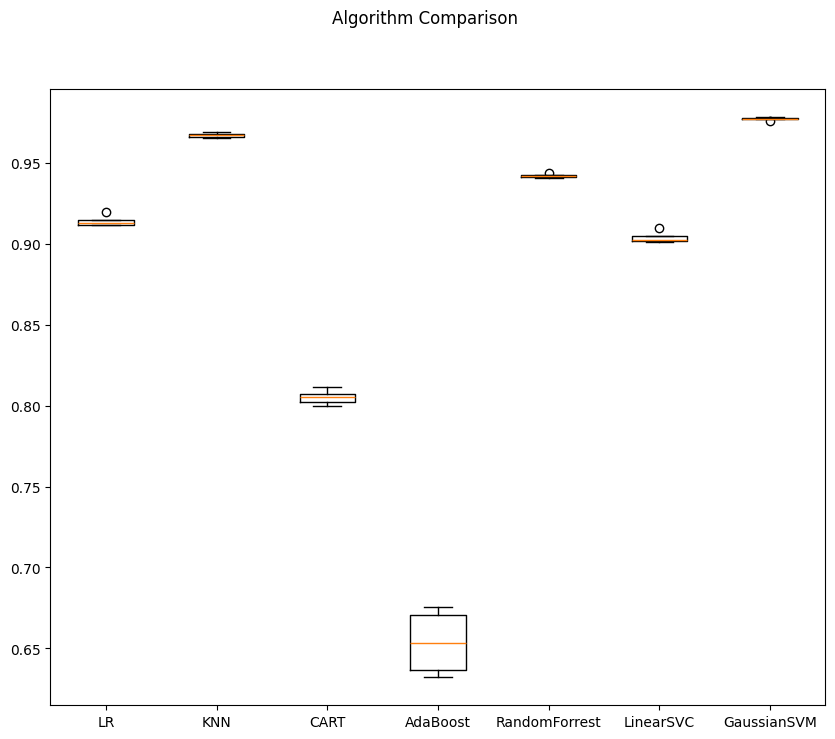

In [32]:
fig = plt.figure(figsize=(10,8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Виждаме, че 3-те най-добри алгоритъма са KNN, Random Forest и GauassianSVM. Понеже Random Forest отенаме повече време ще изберем Ligostic Regression вместо Random Forest.
Оконачтелно избираме KNN, GauassianSVM и Logistic Regression моделите за допълнителни подобрения и тестване на различни хипермараметри. 

### Logistic Regression

In [34]:
# това е списъка, където ще пазим подобрените модели
models = []

In [35]:
model = LogisticRegression()
parameters_grid = [{
    "C": [ 1, 10, 100, 1000, 10000],
    "solver": ['lbfgs','liblinear']
}]
model_fit = fit_model(model, parameters_grid, k_fold)

C:\Users\Atanas.Vasilev\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Atanas.Vasilev\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

In [ ]:
# разкоментирай долния ред код, ако не искаш да чакаш тренирането на LogisticRegression модела
# model_fit = load("LogisticRegression-BACKUP.sav")

In [36]:
model_fit

{'model': 'LogisticRegression',
 'number_of_observations_training': 29400,
 'number_features_training': 87,
 'explained_variance_after_pca': 0.9005709788011417,
 'best_estimator': LogisticRegression(C=100),
 'best_params': {'C': 100, 'solver': 'lbfgs'},
 'best_score': 0.9143197278911565,
 'time_sec': 263.3169934749603}

In [37]:
print("Mean cross-validated score of the best_estimator {0:.3%}".format(model_fit["best_score"]))

Mean cross-validated score of the best_estimator 91.432%


Добре, оценката от крос валидацията не се повиши толкова много. Сега ще видим резултата на модела с тестовия набор от данни.

In [38]:
best_model = model_fit['best_estimator']
score = best_model.score(X_ts, y_ts)
print("Test score {0:.3%}".format(score))

Test score 91.524%


Тестовата оценка е добра върху данни, които никога преди не са били видяни, което означава, че моделът обобщава добре. Ще добавим тестовата оценка към нашия речник с информация за моделите, където съхраняваме информацията за моделите.

In [40]:
model_fit["test_score"] = score

Да разгледаме confusion matrix, за да видим каква е класификацията.

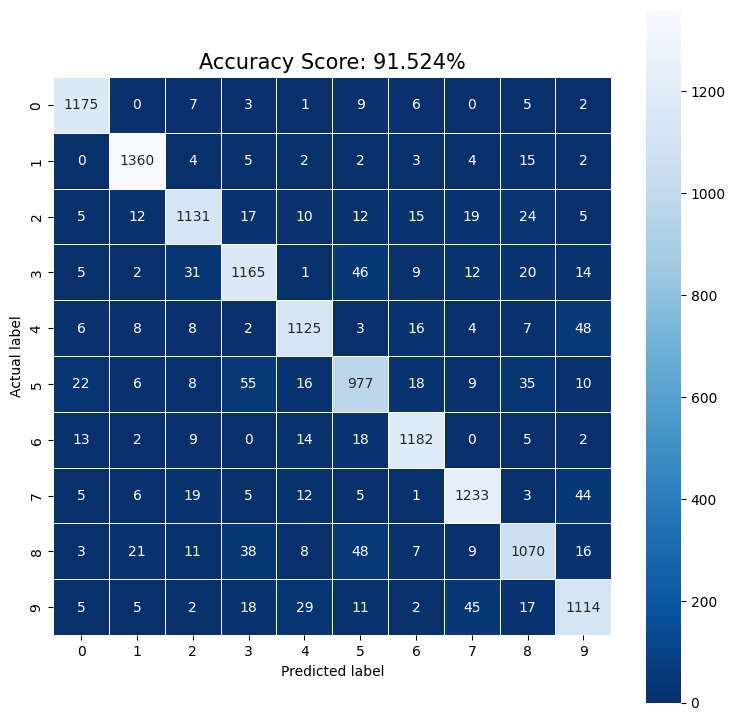

In [41]:
predictions = best_model.predict(X_ts)
draw_confusion_marix(y_ts, predictions, score)

In [42]:
print(classification_report(y_ts, predictions))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1208
           1       0.96      0.97      0.96      1397
           2       0.92      0.90      0.91      1250
           3       0.89      0.89      0.89      1305
           4       0.92      0.92      0.92      1227
           5       0.86      0.85      0.85      1156
           6       0.94      0.95      0.94      1245
           7       0.92      0.92      0.92      1333
           8       0.89      0.87      0.88      1231
           9       0.89      0.89      0.89      1248

    accuracy                           0.92     12600
   macro avg       0.91      0.91      0.91     12600
weighted avg       0.91      0.92      0.92     12600



In [47]:
# запазване на модела в текущата директория и запазване на ексел файл с параметрите на модела
persist_data(models, model_fit)

### Gaussian SVM

In [ ]:
model = SVC(cache_size=1000)
parameters_grid = [{
    "C": [5, 10, 20],
    "gamma": [0.01, 0.05, 0.1]
}]
model_fit = fit_model(model, parameters_grid, k_fold)